# Setting Up

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Exploratory Data Analysis

## Initial Data Checks

In [3]:
df = pd.read_csv('Obesity prediction.csv')
print("Dataset Shape:", df.shape)
df.info()
print("\nMissing Values:\n", df.isnull().sum())
df.describe(include='all')

Dataset Shape: (2111, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: floa

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
count,2111,2111.000000,2111.000000,2111.000000,2111,2111,2111.000000,2111.000000,2111,2111,2111.000000,2111,2111.000000,2111.000000,2111,2111,2111
unique,2,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,4,5,7
top,Male,NaN,NaN,NaN,yes,yes,NaN,NaN,Sometimes,no,NaN,no,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,NaN,NaN,NaN,1726,1866,NaN,NaN,1765,2067,NaN,2015,NaN,NaN,1401,1580,351
mean,NaN,24.312600,1.701677,86.586058,NaN,NaN,2.419043,2.685628,NaN,NaN,2.008011,NaN,1.010298,0.657866,NaN,NaN,NaN
std,NaN,6.345968,0.093305,26.191172,NaN,NaN,0.533927,0.778039,NaN,NaN,0.612953,NaN,0.850592,0.608927,NaN,NaN,NaN
min,NaN,14.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,19.947192,1.630000,65.473343,NaN,NaN,2.000000,2.658738,NaN,NaN,1.584812,NaN,0.124505,0.000000,NaN,NaN,NaN
50%,NaN,22.777890,1.700499,83.000000,NaN,NaN,2.385502,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.625350,NaN,NaN,NaN
75%,NaN,26.000000,1.768464,107.430682,NaN,NaN,3.000000,3.000000,NaN,NaN,2.477420,NaN,1.666678,1.000000,NaN,NaN,NaN


In [4]:
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Target Variable Distribution

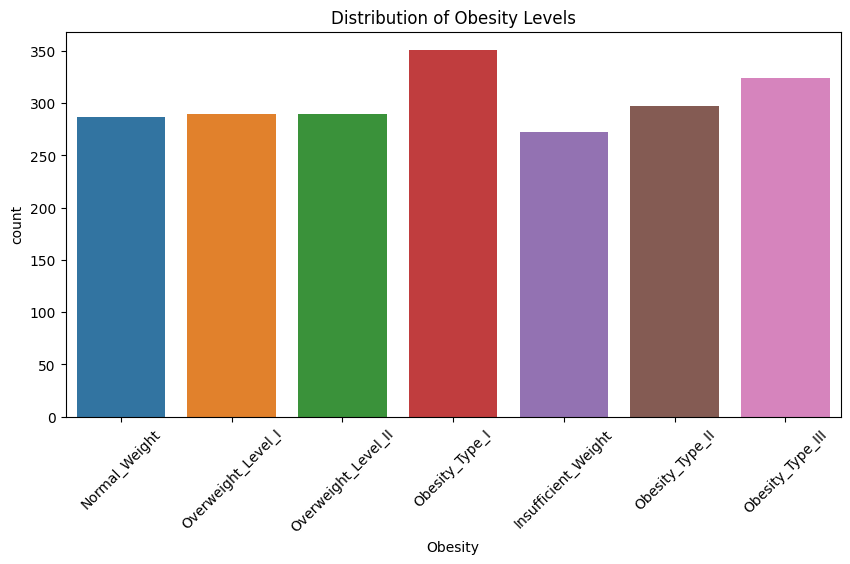

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Obesity')
plt.xticks(rotation=45)
plt.title('Distribution of Obesity Levels')
plt.show()

## Data Type Conversion

In [6]:
#categorical_columns = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'Obesity']

#for column in categorical_columns:
#    label_encoder = LabelEncoder()
#    df[column + '_encoded'] = label_encoder.fit_transform(df[column])

#df.head()

## Binning of Variables

In [7]:
fcvc_labels = {
    1: 'Never',
    2: 'Sometimes',
    3: 'Always'
}
df['FCVC_cat'] = df['FCVC'].round().astype(int).map(fcvc_labels)

ch2o_labels = {
    1: '<1L',
    2: '1-2L',
    3: '>2L',
}
df['CH2O_cat'] = df['CH2O'].round().astype(int).map(ch2o_labels)

faf_labels = {
    0: 'I do not',
    1: '1 - 2 days',
    2: '2 - 4 days',
    3: '4 - 5 days'
}
df['FAF_cat'] = df['FAF'].round().astype(int).map(faf_labels)

tue_labels = {
    0: '0-2h',
    1: '3-5h',
    2: '>5h'
}
df['TUE_cat'] = df['TUE'].round().astype(int).map(tue_labels)

df = df.drop(columns=['FCVC', 'CH2O', 'FAF', 'TUE'])

df.head()

,Gender,Age,Height,Weight,family_history,FAVC,NCP,CAEC,SMOKE,SCC,CALC,MTRANS,Obesity,FCVC_cat,CH2O_cat,FAF_cat,TUE_cat
0,Female,21.0,1.62,64.0,yes,no,3.0,Sometimes,no,no,no,Public_Transportation,Normal_Weight,Sometimes,1-2L,I do not,3-5h
1,Female,21.0,1.52,56.0,yes,no,3.0,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight,Always,>2L,4 - 5 days,0-2h
2,Male,23.0,1.80,77.0,yes,no,3.0,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight,Sometimes,1-2L,2 - 4 days,3-5h
3,Male,27.0,1.80,87.0,no,no,3.0,Sometimes,no,no,Frequently,Walking,Overweight_Level_I,Always,1-2L,2 - 4 days,0-2h
4,Male,22.0,1.78,89.8,no,no,1.0,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II,Sometimes,1-2L,I do not,0-2h


## Outlier Analysis

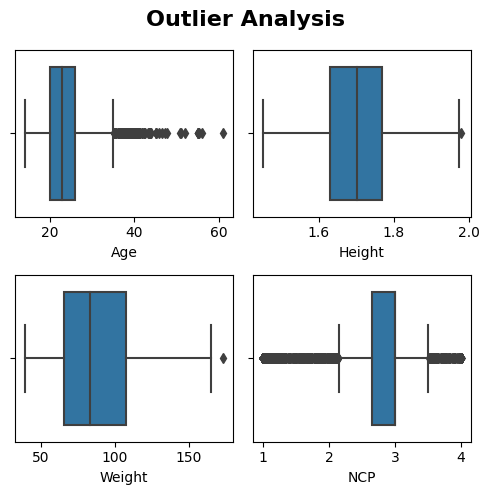

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
sns.boxplot(data=df, x='Age', ax=axes[0, 0])
sns.boxplot(data=df, x='Height', ax=axes[0, 1])
sns.boxplot(data=df, x='Weight', ax=axes[1, 0])
sns.boxplot(data=df, x='NCP', ax=axes[1, 1])
fig.suptitle("Outlier Analysis", fontsize=16, fontweight='bold')
plt.tight_layout()

From the boxplot distributions, we can see that there are many outliers on the higher end above the age of 35.

In [9]:
count = 0
for a in df['Age']:
    if a >= 50:
        count += 1
print(count)

10


Since there are only 10 rows out of 2111 where age >= 50, we can cap extreme values 50 and above since they are very rare.

In [10]:
df['Age'] = df['Age'].clip(upper=49)
print(df['Age'].max()) 

49.0


# Feature Engineering

To enhance predictive power and model interpretability, we can create and transform features to better represent the underlying patterns in our data.

## Bin 'Age' Variable

In [11]:
# Define bin edges and labels
bins = [0, 18, 35, 50, 65, 100]
labels = ['Teen', 'Young Adult', 'Adult', 'Middle Aged', 'Senior']

# Apply binning
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Label encode
#label_encoder = LabelEncoder()
#df['Age_Group_encoded'] = label_encoder.fit_transform(df['Age_Group'])
#df = df.drop(columns=['Age_Group'])

df.head()

,Gender,Age,Height,Weight,family_history,FAVC,NCP,CAEC,SMOKE,SCC,CALC,MTRANS,Obesity,FCVC_cat,CH2O_cat,FAF_cat,TUE_cat,Age_Group
0,Female,21.0,1.62,64.0,yes,no,3.0,Sometimes,no,no,no,Public_Transportation,Normal_Weight,Sometimes,1-2L,I do not,3-5h,Young Adult
1,Female,21.0,1.52,56.0,yes,no,3.0,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight,Always,>2L,4 - 5 days,0-2h,Young Adult
2,Male,23.0,1.80,77.0,yes,no,3.0,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight,Sometimes,1-2L,2 - 4 days,3-5h,Young Adult
3,Male,27.0,1.80,87.0,no,no,3.0,Sometimes,no,no,Frequently,Walking,Overweight_Level_I,Always,1-2L,2 - 4 days,0-2h,Young Adult
4,Male,22.0,1.78,89.8,no,no,1.0,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II,Sometimes,1-2L,I do not,0-2h,Young Adult


## Create BMI from Height and Weight

In [12]:
# Create BMI feature
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

df.head()

,Gender,Age,Height,Weight,family_history,FAVC,NCP,CAEC,SMOKE,SCC,CALC,MTRANS,Obesity,FCVC_cat,CH2O_cat,FAF_cat,TUE_cat,Age_Group,BMI
0,Female,21.0,1.62,64.0,yes,no,3.0,Sometimes,no,no,no,Public_Transportation,Normal_Weight,Sometimes,1-2L,I do not,3-5h,Young Adult,24.386526
1,Female,21.0,1.52,56.0,yes,no,3.0,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight,Always,>2L,4 - 5 days,0-2h,Young Adult,24.238227
2,Male,23.0,1.80,77.0,yes,no,3.0,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight,Sometimes,1-2L,2 - 4 days,3-5h,Young Adult,23.765432
3,Male,27.0,1.80,87.0,no,no,3.0,Sometimes,no,no,Frequently,Walking,Overweight_Level_I,Always,1-2L,2 - 4 days,0-2h,Young Adult,26.851852
4,Male,22.0,1.78,89.8,no,no,1.0,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II,Sometimes,1-2L,I do not,0-2h,Young Adult,28.342381


# Feature Selection

## Variance Threshold

Features with low variability are unlikely to be very informative. Thus, we can set a variance threshold of say 0.01 to weed out features that are not useful in our analysis.

In [13]:
df_var_threshold = df.drop(columns=['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'Obesity', 'FCVC_cat', 'CH2O_cat', 'FAF_cat', 'TUE_cat', 'Age_Group'])
selector = VarianceThreshold(threshold=0.01)
selector.fit(df_var_threshold)
mask = selector.get_support()  # Boolean mask: True = kept, False = removed

# Get all column names
all_features = df_var_threshold.columns

# Get names of features that were removed (False in the mask)
removed_features = all_features[~mask]

print("Features to Remove:", list(removed_features))

# Drop features with low variance
df = df.drop(columns=removed_features)

Features to Remove: ['Height']


## Correlation Matrix

To see the pairwise correlation coefficients between numeric and ordinal variables. Nominal variables are not included as they will cause correlation to be misleading. This correlation maxtrix allows us to identify multicollinearity and remove the variables causing this phenomenon. Moreover, we can also infer the correlations between the feature variables and the target variable 'Obesity_encoded'.

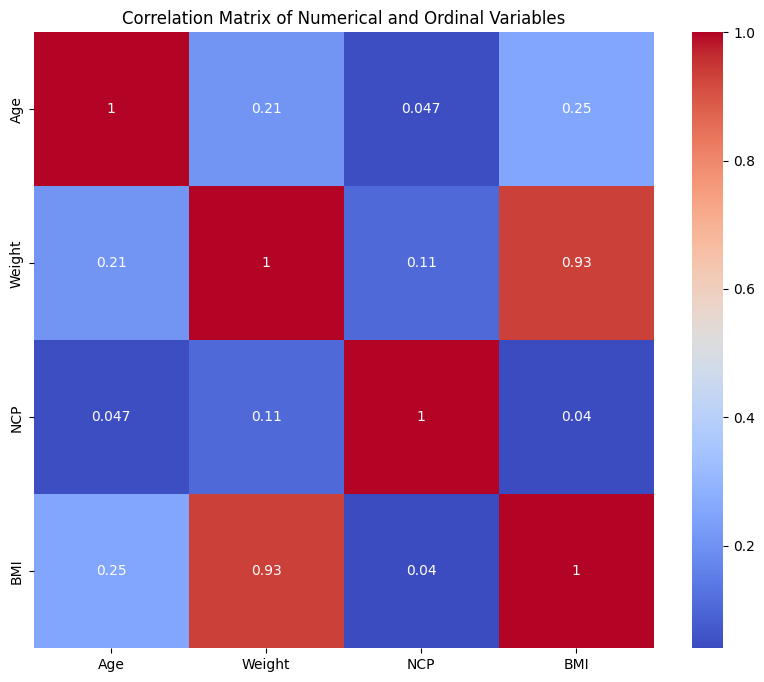

Features to Remove: {'Weight'}


,Gender,Age,family_history,FAVC,NCP,CAEC,SMOKE,SCC,CALC,MTRANS,Obesity,FCVC_cat,CH2O_cat,FAF_cat,TUE_cat,Age_Group,BMI
0,Female,21.0,yes,no,3.0,Sometimes,no,no,no,Public_Transportation,Normal_Weight,Sometimes,1-2L,I do not,3-5h,Young Adult,24.386526
1,Female,21.0,yes,no,3.0,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight,Always,>2L,4 - 5 days,0-2h,Young Adult,24.238227
2,Male,23.0,yes,no,3.0,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight,Sometimes,1-2L,2 - 4 days,3-5h,Young Adult,23.765432
3,Male,27.0,no,no,3.0,Sometimes,no,no,Frequently,Walking,Overweight_Level_I,Always,1-2L,2 - 4 days,0-2h,Young Adult,26.851852
4,Male,22.0,no,no,1.0,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II,Sometimes,1-2L,I do not,0-2h,Young Adult,28.342381


In [14]:
df_corr_matrix = df.drop(columns=['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'Obesity', 'FCVC_cat', 'CH2O_cat', 'FAF_cat', 'TUE_cat', 'Age_Group'])

# Compute correlation matrix
corr_matrix = df_corr_matrix.corr().abs()

# Create a mask for upper triangle (since correlation matrix is symmetric)
mask = np.triu(np.ones(corr_matrix.shape), k=1)

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical and Ordinal Variables")
plt.show()

# Set correlation threshold
corr_threshold = 0.5

# Find highly correlated features
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[j, i] > corr_threshold:
            colname = corr_matrix.columns[j]  # Feature to remove
            high_corr_features.add(colname)
print("Features to Remove:", high_corr_features)

# Drop the highly correlated features
df = df.drop(columns=high_corr_features)
df.head()

From the correlation matrix, we can infer that 'CAEC_encoded' and 'BMI' have the highest correlations with target variable 'Obesity_encoded'.

# CatBoost Tree-Based Model

## Choice of Features
We used the filtered features from our preliminary data analysis. Since CatBoost handles categorical variables well, we excluded the encoded categorical variables so that there will not be overlaps when training the model.

## Train-Test-Validation Splitting
To ensure robust model performance, the dataset was split into training, validation, and test sets.

Train-Test Split (80-20): The dataset was split into 80% training and 20% testing. This ensures that the model learns from 80% of the data while keeping 20% unseen for final evaluation. 

Train-Validation Split (Within Training Set): The 80% training data was further split into train (70%) and validation (10%). The validation set was used for hyperparameter tuning (Optuna). This ensures that hyperparameters are optimized on a separate validation set, preventing overfitting.

## Overfitting Considerations
Since our dataset only has 2110 rows, which is relatively small, we put in place measures to try reduce overfitting of data as much as possible. One of such measures include using a validation set. We also used early stopping rounds to monitor validation loss, which prevents training too long on noisy patterns. Additionally, we tweaked CatBoost's regularisation hyperparameters to increase regularisation.

In [15]:
# Features and target
X = df.drop(columns=['Obesity'])
y = df['Obesity']

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train-Validation Split (70-10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state=42, stratify=y_train)

# Identify categorical features
categorical_features = X.select_dtypes(include={'object','category'}).columns.tolist()

# Initialise 1st CatBoost Model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=4, # Depth reduced from 6 to 4
    l2_leaf_reg=100, # Regularisation
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

# Use Pool to provide validation set
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)

# Train model
model.fit(train_pool, eval_set=val_pool)

# Evaluate on Test Set
y_pred = model.predict(X_test).flatten()
# Classification Report
print("Classification Report for 1st Model\n")
print(classification_report(y_test, y_pred))
# AUC Score
y_pred_proba = model.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC Score: {auc_score:.4f}")
# True Positive and True Negative Rates
cm = confusion_matrix(y_test, y_pred)
n_classes = len(cm)

tpr_per_class = []
tnr_per_class = []

for i in range(n_classes):
    tp = cm[i][i]
    fn = np.sum(cm[i]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - (tp + fn + fp)

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0

    tpr_per_class.append(tpr)
    tnr_per_class.append(tnr)
for i in range(n_classes):
    print(f"Class {i} TPR (Recall): {tpr_per_class[i]:.4f}, TNR (Specificity): {tnr_per_class[i]:.4f}")

0:	learn: 0.7000677	test: 0.7345972	best: 0.7345972 (0)	total: 72.8ms	remaining: 1m 12s
100:	learn: 0.9708869	test: 0.9573460	best: 0.9620853 (88)	total: 995ms	remaining: 8.86s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9668246445
bestIteration = 132

Shrink model to first 133 iterations.
Classification Report for 1st Model

                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.98      0.98        54
      Normal_Weight       0.97      0.97      0.97        58
     Obesity_Type_I       0.96      1.00      0.98        70
    Obesity_Type_II       0.98      1.00      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.97      0.97      0.97        58
Overweight_Level_II       0.98      0.93      0.96        58

           accuracy                           0.98       423
          macro avg       0.98      0.98      0.98       423
       weighted avg       0.98      

## CatBoost Feature Selection 

           feature  importance
15             BMI   88.835648
0           Gender   10.693001
4              NCP    0.271049
1              Age    0.178645
3             FAVC    0.021657
2   family_history    0.000000
5             CAEC    0.000000
6            SMOKE    0.000000
7              SCC    0.000000
8             CALC    0.000000


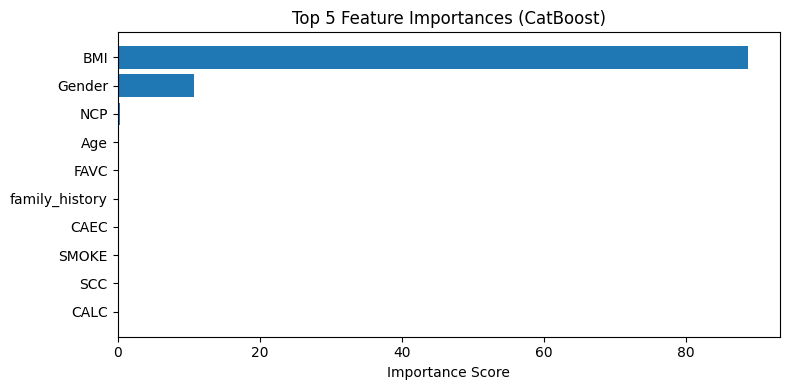

In [16]:
# Get feature importance
importances = model.get_feature_importance()
feature_names = X_train.columns

# Combine into a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Print top 5 features and their importance scores
print(feat_imp_df.head(10))

# Plot graph to show the Top 5 Feature Importances
top_k = 10
top_features = feat_imp_df['feature'].head(top_k).tolist()

plt.figure(figsize=(8, 4))
plt.barh(feat_imp_df['feature'].head(top_k), feat_imp_df['importance'].head(top_k))
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.title('Top 5 Feature Importances (CatBoost)')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning using Optuna
Mainly to prevent overfitting

In [17]:
# Define objective function
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 300, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 100.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "loss_function": "MultiClass",
        "eval_metric": "Accuracy",
        "verbose": 0,
        "random_seed": 42,
    }

    model = CatBoostClassifier(**params)
    
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
    
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Run Optuna study
study = optuna.create_study(direction="maximize")  # for accuracy
study.optimize(objective, n_trials=50)

print("Best parameters:")
print(study.best_params)

print(f"Best validation accuracy: {study.best_value:.4f}")

[I 2025-04-17 17:43:34,322] A new study created in memory with name: no-name-60a41e57-5366-4f86-95cc-a205111d4fa7
[I 2025-04-17 17:43:35,801] Trial 0 finished with value: 0.9478672985781991 and parameters: {'iterations': 615, 'depth': 6, 'learning_rate': 0.010085295789085886, 'l2_leaf_reg': 0.04491443097325893, 'bagging_temperature': 0.6435328513889861, 'border_count': 154, 'random_strength': 0.0011288356172580755}. Best is trial 0 with value: 0.9478672985781991.
[I 2025-04-17 17:43:42,024] Trial 1 finished with value: 0.966824644549763 and parameters: {'iterations': 526, 'depth': 8, 'learning_rate': 0.08339924257879258, 'l2_leaf_reg': 0.7923822116776819, 'bagging_temperature': 0.5918922954844644, 'border_count': 229, 'random_strength': 0.002728899906120571}. Best is trial 1 with value: 0.966824644549763.
[I 2025-04-17 17:43:51,916] Trial 2 finished with value: 0.976303317535545 and parameters: {'iterations': 524, 'depth': 8, 'learning_rate': 0.16736265519823273, 'l2_leaf_reg': 0.01050

Best parameters:
{'iterations': 534, 'depth': 9, 'learning_rate': 0.2968429277086801, 'l2_leaf_reg': 0.12813658480038978, 'bagging_temperature': 0.4014807183515267, 'border_count': 96, 'random_strength': 4.198482963904999}
Best validation accuracy: 0.9953


## Train 2nd Model with updated Features and Hyperparameters

0:	learn: 1.7953435	test: 1.8081310	best: 1.8081310 (0)	total: 2.56ms	remaining: 1.36s
1:	learn: 1.3516154	test: 1.3557275	best: 1.3557275 (1)	total: 13.9ms	remaining: 3.71s
2:	learn: 1.1771565	test: 1.1786657	best: 1.1786657 (2)	total: 16.7ms	remaining: 2.95s
3:	learn: 1.0068694	test: 1.0145163	best: 1.0145163 (3)	total: 20.8ms	remaining: 2.76s
4:	learn: 0.8836494	test: 0.8957920	best: 0.8957920 (4)	total: 27.4ms	remaining: 2.89s
5:	learn: 0.8541880	test: 0.8667610	best: 0.8667610 (5)	total: 30.3ms	remaining: 2.67s
6:	learn: 0.7990820	test: 0.8078886	best: 0.8078886 (6)	total: 32.6ms	remaining: 2.45s
7:	learn: 0.7384455	test: 0.7500457	best: 0.7500457 (7)	total: 36.5ms	remaining: 2.4s
8:	learn: 0.7126116	test: 0.7216309	best: 0.7216309 (8)	total: 59.7ms	remaining: 3.48s
9:	learn: 0.7121355	test: 0.7216147	best: 0.7216147 (9)	total: 62.3ms	remaining: 3.26s
10:	learn: 0.6083451	test: 0.6223520	best: 0.6223520 (10)	total: 67.2ms	remaining: 3.2s
11:	learn: 0.5740535	test: 0.5918515	best: 

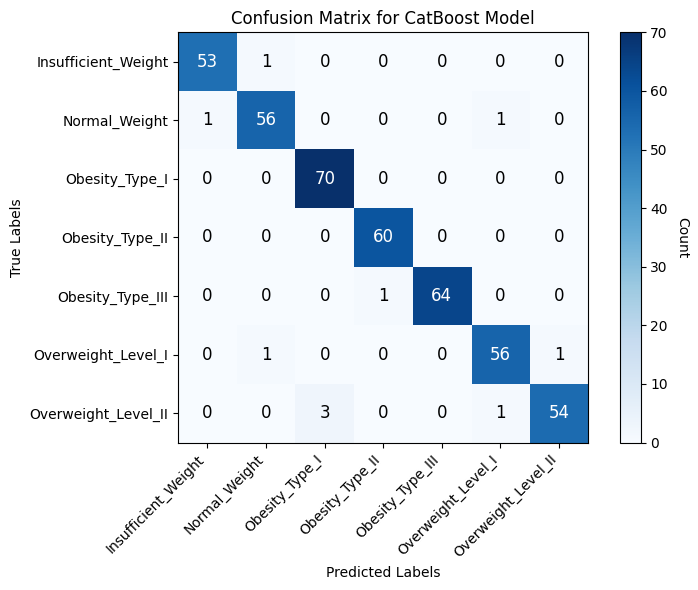

Class 0 TPR (Recall): 0.9815, TNR (Specificity): 0.9973
Class 1 TPR (Recall): 0.9655, TNR (Specificity): 0.9945
Class 2 TPR (Recall): 1.0000, TNR (Specificity): 0.9915
Class 3 TPR (Recall): 1.0000, TNR (Specificity): 0.9972
Class 4 TPR (Recall): 0.9846, TNR (Specificity): 1.0000
Class 5 TPR (Recall): 0.9655, TNR (Specificity): 0.9945
Class 6 TPR (Recall): 0.9310, TNR (Specificity): 0.9973


In [24]:
# Filter X_train, X_val, and X_test to keep only top features
X_train_top = X_train[top_features]
X_val_top = X_val[top_features]
X_test_top = X_test[top_features]

# Identify categorical features in top features
categorical_top_features = [f for f in categorical_features if f in top_features]
categorical_top_features = X_train_top.select_dtypes(include='object').columns.tolist()

# Initialise 2nd model with best parameters
model_top = CatBoostClassifier(**study.best_params)

# Use Pool to provide validation set
train_top_pool = Pool(X_train_top, y_train, cat_features=categorical_top_features)
val_top_pool = Pool(X_val_top, y_val, cat_features=categorical_top_features)

model_top.fit(train_top_pool, eval_set=val_top_pool)

# Evaluate on Test Set
y_pred = model_top.predict(X_test_top).flatten()
# Classification Report
print("Classification Report for 1st Model\n")
print(classification_report(y_test, y_pred))
# AUC Score
y_pred_proba = model.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average="macro")
print(f"AUC Score: {auc_score:.4f}")
# 1. Compute the confusion matrix
labels = ["Insufficient_Weight",
          "Normal_Weight",
          "Obesity_Type_I",
          "Obesity_Type_II",
          "Obesity_Type_III",
          "Overweight_Level_I",
          "Overweight_Level_II"]
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# Plot Confusion Matrix
#disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
#plt.title("CatBoost Model Confusion Matrix")
#plt.tight_layout()
#plt.show()
# 2. Plot using plt.imshow with a blue colormap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

# 3. Add the colorbar to the right
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Count', rotation=270, labelpad=15)

# 4. Set tick labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0)

# 5. Annotate each cell with its count
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if cm[i, j] > thresh else 'black'
        ax.text(j, i, f"{cm[i, j]:d}",
                ha="center", va="center", color=color, fontsize=12)

# 6. Labels and title
ax.set_title("Confusion Matrix for CatBoost Model")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

plt.tight_layout()
plt.show()
n_classes = len(cm)

tpr_per_class = []
tnr_per_class = []

for i in range(n_classes):
    tp = cm[i][i]
    fn = np.sum(cm[i]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - (tp + fn + fp)

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0

    tpr_per_class.append(tpr)
    tnr_per_class.append(tnr)
for i in range(n_classes):
    print(f"Class {i} TPR (Recall): {tpr_per_class[i]:.4f}, TNR (Specificity): {tnr_per_class[i]:.4f}")

Top Features Used in Predicting Obesity:
          feature  importance
0             BMI   63.092090
1          Gender   13.604511
3             Age    6.981267
2             NCP    5.104296
9            CALC    5.050963
6            CAEC    3.001215
5  family_history    1.577390
4            FAVC    1.146101
8             SCC    0.442168
7           SMOKE    0.000000


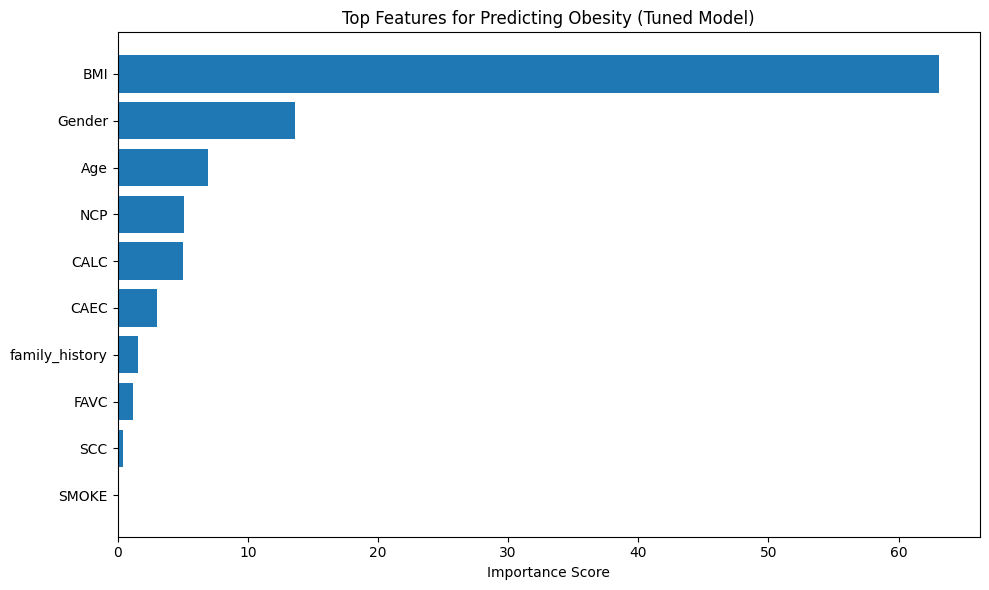

In [19]:
importances = model_top.get_feature_importance(train_top_pool)
feature_names = X_train_top.columns

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_k = 10
print("Top Features Used in Predicting Obesity:")
print(feat_imp_df.head(top_k))

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['feature'].head(top_k), feat_imp_df['importance'].head(top_k))
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.title('Top Features for Predicting Obesity (Tuned Model)')
plt.tight_layout()
plt.show()